In [436]:
import pandas as pd
import numpy as np
from xgboost import XGBRFClassifier, XGBClassifier, plot_importance
from sklearn.model_selection import (
                train_test_split, cross_val_score, cross_validate,
                GridSearchCV, RandomizedSearchCV              
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, auc, roc_auc_score, roc_curve, 
                            confusion_matrix, f1_score, precision_score, 
                            plot_confusion_matrix, recall_score, classification_report
                            )
import matplotlib.pyplot as plt
from sklearn.naive_bayes import (GaussianNB, BernoulliNB
                                )
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

# Business Understanding

## Taarifa has collected data regarding water sources in Tanzania. In order to save the government of Tanzania money I will determine which factors are most likely to cause water pump failure. To do this I will construct a machine learning model that will predict if a water source is faulty or not. Once I have confirmed my model is reliable, I will break down which independent variables are most correlated with faulty water sources. This will allow water source providers to more about why their water pumps are failing.

# Business Problem

## The government of Tanzania is obligated to provide accessible clean water to it's citizens. However, they are spending too much money for maintenance & repair on the water sources. By determining the leading causes in a faulty water pump the government can prevent mechanical errors. Preventing the faulty pump phenomena will save the government money. Additionally, this data may produce results that are valuable to any organization that builds water pumps.

# Functions

In [2]:
def cross_validate_model(clf, X_train, y_train):
    """
    Prints train and test accuracy scores from a cross_validate.
    
    IN:
        -clf : classifier
        -X_train: train x variables
        -y_train: train target values   
    """
    baseline_scores = cross_validate(
    estimator=clf,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=5,
    scoring='accuracy'

)

    print("Train score:     ", baseline_scores["train_score"].mean())
    print("Test score:", baseline_scores["test_score"].mean())

In [3]:
def determine_len_unique_vals(col):
    """ 
    returns len(col.unique())   
    """
    
    return len(col.unique())
    

In [4]:
def display_confusion_matrix(clf, X, y):
    """
    returns confustion_matrix after calling plot_confustion_matrix
    from sklearn.
    IN:
        -clf : classifier
        -X: train x variables
        -y: train target values   
    
    """
    
    disp = plot_confusion_matrix(clf, X, y,
                                 display_labels=y_test.unique(), 
                                 cmap=plt.cm.Blues)

    return(disp.confusion_matrix)
    

In [5]:
def remove_low_value_counts(df, num_vals_low_limit, column_name):
    """
    Reshapes df after removing indices where the column_name's value counts > num_vals_low_limit
    
    IN:
        -df: Dataframe you want trimmed
        -num_vals_low_limit: col.value_counts() > num_vals_low_limit will be removed
        -column_name: Name of column. Must be in df.
    OUT:
        -trimmed df
       
    """
    
    counts = df[column_name].value_counts()
    new_df = df.loc[df[column_name].isin(counts.index[counts > num_vals_low_limit])]
    return new_df 
        

# The Data


amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# Obtain

In [6]:
target_labels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
data = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960 (1).csv')

# Explore

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Columns with NaN are: 
- funder

- installer

- subvillage

- public_meeting

- scheme_management

- scheme_name

- permit


#### funder, I will replace the NaN values with the string Unknown

In [8]:
#Amount of NaN values
data.funder.isna().sum()

3635

In [9]:
#Replace NaN values with string 'Unknown'
data.funder.fillna('Unknown', inplace=True)

In [10]:
#Amount of NaN values
data.funder.isna().sum()

0

#### installer, I will replace the NaN values with the string Unknown

In [11]:
#Amount of NaN values
data.installer.isna().sum()

3655

In [12]:
#Replace NaN values with string 'Unknown'
data.installer.fillna('Unknown', inplace=True)

In [13]:
data.installer.isna().sum()

0

#### subvillage, I will replace the NaN values with the string Unknown

In [14]:
#Amount of NaN values
data.subvillage.isna().sum()

371

In [15]:
#Replace NaN values with string 'Unknown'
data.subvillage.fillna('Unknown', inplace=True)

In [16]:
#Amount of NaN values
data.subvillage.isna().sum()

0

In [17]:
#Amount of NaN values
data.public_meeting.isna().sum()

3334

#### public_meeting, first I will change the boolean values to strings. Then I will replace the NaN values with the string Unknown

In [19]:
#Amount of NaN values
data.public_meeting.isna().sum()

3334

In [20]:
data.public_meeting = data.public_meeting.apply(lambda val:
                                               'True' if val==True
                                               else('False' if val==False
                                                   else('Unknown')))

In [21]:
#Amount of NaN values
data.public_meeting.isna().sum()

0

#### scheme_management,  I will replace the NaN values with the string Unknown

In [22]:
#Amount of NaN values
data.scheme_management.isna().sum()

3877

In [23]:
#Replace NaN values with string 'Unknown'
data.scheme_management.fillna('Unknown', inplace=True)

In [24]:
#Amount of NaN values
data.scheme_management.isna().sum()

0

#### scheme_name,  I will replace the NaN values with the string Unknown

In [25]:
#Amount of NaN values
data.scheme_name.isna().sum()

28166

In [26]:
#Replace NaN values with string 'Unknown'
data.scheme_name.fillna('Unknown', inplace=True)

In [27]:
#Amount of NaN values
data.scheme_name.isna().sum()

0

#### permit first I will change the boolean values to strings. Then I will replace the NaN values with the string Unknown

In [28]:
#Amount of NaN values
data.permit.isna().sum()

3056

In [29]:
data.permit = data.permit.apply(lambda val:
                             'True' if val==True
                            else('False' if val==False
                         else('Unknown')))

In [30]:
#Amount of NaN values
data.permit.isna().sum()

0

In [32]:
#Adding the target variable to the data dataframe
data['target'] = target_labels.status_group

In [33]:
#Amount of unique values per column in the data dataframe
for col in data.columns:
    print(col)
    print("Has "+str(determine_len_unique_vals(data[col])) +' unique values')
    print()

id
Has 59400 unique values

amount_tsh
Has 98 unique values

date_recorded
Has 356 unique values

funder
Has 1897 unique values

gps_height
Has 2428 unique values

installer
Has 2145 unique values

longitude
Has 57516 unique values

latitude
Has 57517 unique values

wpt_name
Has 37400 unique values

num_private
Has 65 unique values

basin
Has 9 unique values

subvillage
Has 19288 unique values

region
Has 21 unique values

region_code
Has 27 unique values

district_code
Has 20 unique values

lga
Has 125 unique values

ward
Has 2092 unique values

population
Has 1049 unique values

public_meeting
Has 3 unique values

recorded_by
Has 1 unique values

scheme_management
Has 13 unique values

scheme_name
Has 2697 unique values

permit
Has 3 unique values

construction_year
Has 55 unique values

extraction_type
Has 18 unique values

extraction_type_group
Has 13 unique values

extraction_type_class
Has 7 unique values

management
Has 12 unique values

management_group
Has 5 unique values

pay

# Data Preparation

## First I will change numeric features to the correct data type

In [34]:
data_trimmed = data.copy()
# These are numeric columns that need to changes to integers
cols_to_change = ['id',
 'amount_tsh',
 'gps_height',
 'num_private',
 'population',
]
for col in cols_to_change:
    data_trimmed[col] = data_trimmed[col].astype(int)

#### Now I will need to remove low value count columns from the data frame. This is so that when I train test split I am getting the same features in both X_train & X_test.

In [35]:
trim_col_list = []
cols_to_drop = []
for col in data_trimmed.columns:
    #Value Counts of column
    v_counts = data_trimmed[col].value_counts()
    #If there are values with less than 25 occurences
    if True in list(v_counts < 25):
        #If the values with less than 25 occurences occur less than 50 times
        if ((v_counts < 25).sum() < 50):         
            trim_col_list.append(col)
        #These columns have too many value_counts<25. Some of these will be dropped
        else:
            cols_to_drop.append(col)    

In [36]:
#Updatedd list of columns to drop
cols_to_drop = ['id', 'date_recorded', 'funder', 'scheme_name','installer','ward',
               'subvillage','wpt_name','latitude','longitude', 'target']

In [37]:
data_trimmed.shape

(59400, 41)

In [38]:
#Removing occurences where value_count < 25 from the entire data frame
cut_off = 25
for col in trim_col_list:
    data_trimmed = remove_low_value_counts(data_trimmed, cut_off, col)

In [39]:
data_trimmed.shape

(59253, 41)

# Train Test Split

In [219]:
X = data_trimmed.drop(columns=cols_to_drop)
y = data_trimmed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

 #### From intuition, I have developed the rudimentary list below to start as our relevant features. After model selection and optimization I will revisit which features are the most important.

## Categorical & Continuous

In [228]:
relevant_categorical_columns = ['basin', 
                                'region',
                                'lga',
                                'public_meeting',
                                'scheme_management', 
                                'permit', 
                                
                                'extraction_type_class',
                                'management', 'payment',
                                'water_quality', 'source',
                                'waterpoint_type'
                               ]
relevant_numeric_columns = ['amount_tsh', 'gps_height', 'population']

X_train_cat = X_train[relevant_categorical_columns]
X_test_cat = X_test[relevant_categorical_columns]

X_train_cont = X_train[relevant_numeric_columns]
X_test_cont = X_test[relevant_numeric_columns]

# OHE

In [42]:
ohe = OneHotEncoder(drop='first', sparse=False )
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train_cat), columns = ohe.get_feature_names(relevant_categorical_columns))
X_test_encoded = pd.DataFrame(ohe.transform(X_test_cat), columns = ohe.get_feature_names(relevant_categorical_columns))

# Scale

In [43]:
#Scale
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_cont), columns=X_train_cont.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test_cont), columns = X_test_cont.columns)

# Concat

In [44]:
X_train_processed = pd.concat([X_train_encoded, X_train_scaled], axis = 1)
X_test_processed = pd.concat([X_test_encoded, X_test_scaled], axis = 1)

# Modeling

## Logistic Regression (BASELINE)

In [45]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000)

In [46]:
cross_validate_model(lr, X_train_processed, y_train)

Train score:      0.7093768984750575
Test score: 0.7031887134364387


array([[20604,   189,  3339],
       [ 2085,   401,   757],
       [ 6433,   132, 10499]])

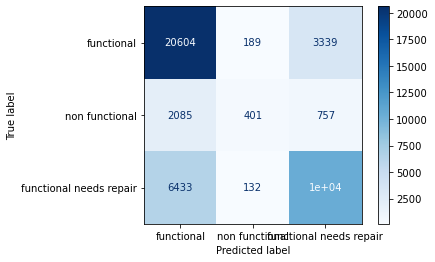

In [47]:
display_confusion_matrix(lr, X_train_processed, y_train)

## KNN Classifier

In [48]:
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

In [49]:
cross_validate_model(knn, X_train_processed, y_train)

Train score:      0.784823019305109
Test score: 0.7265915853991161


array([[21218,   441,  2473],
       [ 1661,  1161,   421],
       [ 4064,   338, 12662]])

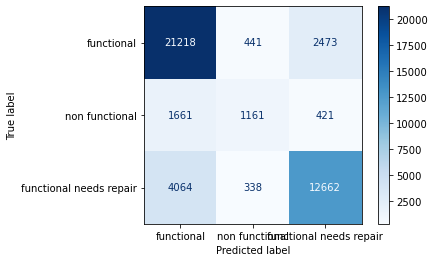

In [50]:
display_confusion_matrix(knn, X_train_processed, y_train)

## Bayes Classifier

In [51]:
nb = GaussianNB()
nb.fit(X_train_processed, y_train)

GaussianNB()

In [52]:
cross_validate_model(nb, X_train_processed, y_train)

Train score:      0.280862521675925
Test score: 0.27732378841574945


array([[ 6025, 16041,  2066],
       [   62,  3114,    67],
       [ 2002, 11350,  3712]])

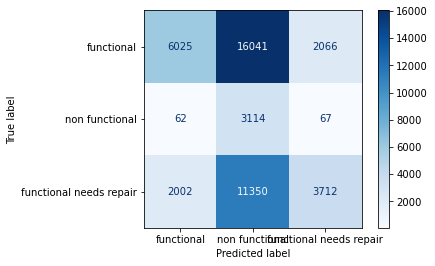

In [53]:
display_confusion_matrix(nb, X_train_processed, y_train)

In [54]:
bnb = BernoulliNB()
bnb.fit(X_train_processed, y_train)

BernoulliNB()

In [55]:
cross_validate_model(bnb, X_train_processed, y_train)

Train score:      0.632760657152042
Test score: 0.6300997107699968


## SVM

In [828]:
svm = svm.SVC()
svm.fit(X_train_processed, y_train)

SVC()

In [836]:
cross_validate_model(svm, X_train_processed, y_train)

Train score:      0.7594736633412715
Test score: 0.7368978717383385


array([[21784,   318,  2030],
       [ 1907,   728,   608],
       [ 5617,   157, 11290]])

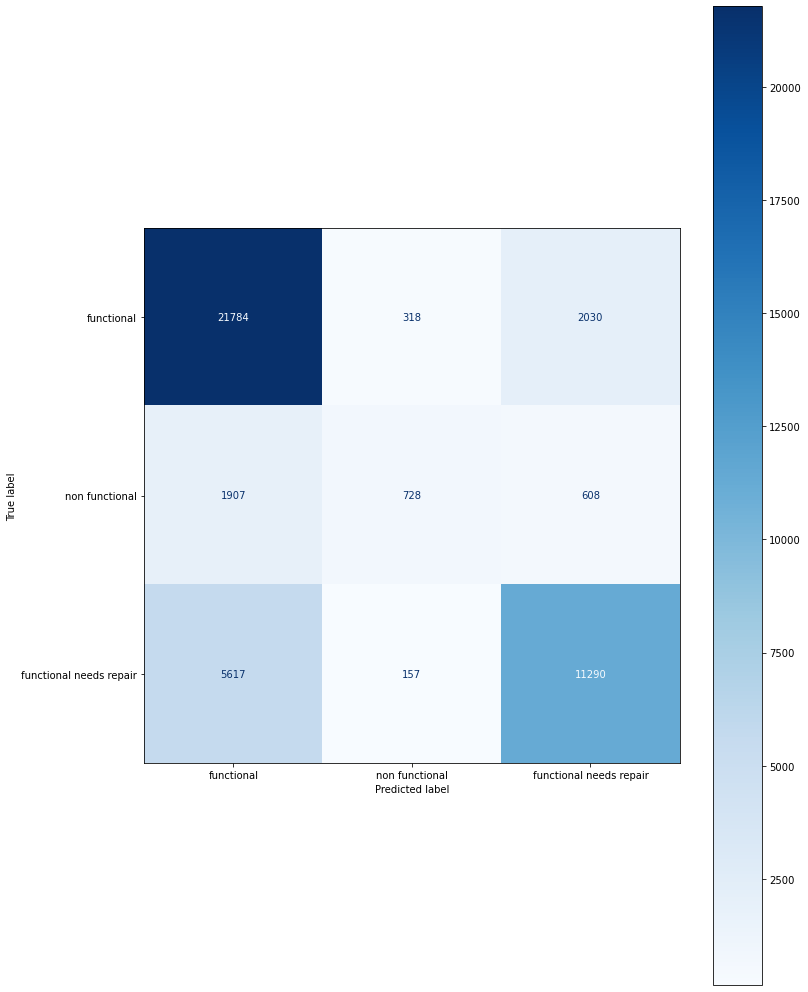

In [716]:
display_confusion_matrix(svm, X_train_processed, y_train)

## RandomForest

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

In [57]:
cross_validate_model(rf, X_train_processed, y_train)

Train score:      0.9195526500942688
Test score: 0.7439862223535283


## XGBOOST

In [58]:
xg = XGBClassifier()
xg.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
cross_validate_model(xg, X_train_processed, y_train)

Train score:      0.7791466989867956
Test score: 0.743918725731018


array([[22103,   176,  1853],
       [ 2041,   730,   472],
       [ 5256,   135, 11673]])

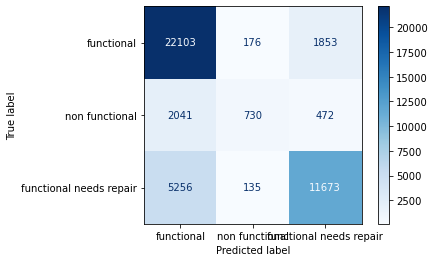

In [60]:
display_confusion_matrix(xg, X_train_processed, y_train)

In [834]:
xg_rbf = XGBRFClassifier()
xg_rbf.fit(X_train_processed, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                scale_pos_weight=None, tree_method='exact',
                validate_parameters=1, verbosity=None)

In [835]:
cross_validate_model(xg_rbf, X_train_processed, y_train)

Train score:      0.6770966940509977
Test score: 0.6734400296674206


# Parameter Optimization

### Because the XtremeGradientBoosted and the RandomForest algorithm perfomed the best I will optimize their parameters using GridSearchCV

## GridSearch Round One (XGBOOST)

### First I will investigate max depth

In [102]:
parameters = {
    'max_depth': range (0, 100, 25)
}
xg = XGBClassifier()
#xg_rbf.fit(X_train_processed, y_train)

In [103]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

In [104]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=None,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_method=None,
                                       validate_parameter

In [105]:
grid_search.best_params_

{'max_depth': 25}

### n_estimators

#### The n_estimators has been optimized at 1. Max Depth could be higher and learning rate could be lower.

In [106]:
parameters = {
    'n_estimators': range (0, 100, 25)
}
xg = XGBClassifier(max_depth=25)

In [107]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

In [108]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/johnwelsh/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.7445262  0.74493125 0.74553883]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=25,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_method=None,
                                       validate_parameters=

In [109]:
grid_search.best_params_

{'n_estimators': 75}

#### Learning Rate

In [110]:
parameters = {
    'learning_rate': range (1, 10, 1)
}
xg = XGBClassifier(max_depth=25, n_estimators = 75)

In [111]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 3,
    cv = 3,
    verbose=True
)

In [112]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       colsample_bylevel=None,
                                       colsample_bytree=None, gamma=None,
                                       gpu_id=None, importance_type='gain',
                                       interaction_constraints=None,
                                       max_delta_step=None, max_depth=25,
                                       min_child_weight=None, missing=nan,
                                       monotone_constraints=None,
                                       n_estimators=75, n_jobs=None,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None,
                                       scale_pos_weight=None, tree_method=None,
                                       validate_parameters=N

In [114]:
grid_search.best_params_

{'learning_rate': 1}

In [138]:
xg = XGBClassifier(max_depth=6, n_estimators = 100, learning_rate=.75)

In [139]:
cross_validate_model(xg, X_train_processed, y_train)

Train score:      0.8299860574156203
Test score: 0.7469791558316403


## GridSearch Round Two (RandomForest)

In [67]:
rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

RandomForestClassifier()

#### First, I will use a random CV search to determine a starting point for the GridSearchCV

In [68]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [69]:

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_processed, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [71]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [75]:
#Train score:      0.9195526500942688
#Test score: 0.7439862223535283
rf = RandomForestClassifier(n_estimators= 800,
 min_samples_split= 2,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 50,
 bootstrap= False)
rf.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=800)

In [76]:
cross_validate_model(rf, X_train_processed, y_train)

Train score:      0.8316737643181493
Test score: 0.75404493076741


#### Our test score improved! The high train score implies that the model is still overfit and we might be able to push the test score higher. I will investigate each of the following parameters n_estimators, max_features, max_depth, min_samples_leaf. I will do them one at a time for time's sake.
### n_estimators

In [81]:
parameters = {
    'n_estimators' : range(750, 850, 10)
}

In [82]:
rf = RandomForestClassifier(min_samples_split= 2,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 50,
 bootstrap= False )
rf.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2)

In [83]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 5,
    cv = 3,
    verbose=True
)

In [84]:
grid_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, max_depth=50,
                                              max_features='sqrt',
                                              min_samples_leaf=2),
             n_jobs=5, param_grid={'n_estimators': range(750, 850, 10)},
             scoring='accuracy', verbose=True)

In [86]:
grid_search.best_params_

{'n_estimators': 830}

In [161]:
rf = RandomForestClassifier(max_features='sqrt',
                            min_samples_leaf = 2,
                            min_samples_split=2,
                            n_estimators = 820,
                            max_depth = 60,
                            random_state = 42
                    
                           )

In [141]:
rf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=830)

In [162]:
cross_validate_model(rf, X_train_processed, y_train)
#was 0.7522672200830975
#RandomForestClassifier(max_depth=60, max_features='sqrt', min_samples_leaf=2,
#                       n_estimators=820)

Train score:      0.8090022368949505
Test score: 0.7522222358389772


# Final Feature Selection
### Now that I have a validated model I will revisit which features are relevant or not. I will first remove features displaying collinearity and then I may remove features deemed unimportant by the model. For testing convenience, I will first develop the pipeline.

# Pipeline

In [165]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44439 entries, 11045 to 56561
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   amount_tsh             44439 non-null  int64 
 1   gps_height             44439 non-null  int64 
 2   num_private            44439 non-null  int64 
 3   basin                  44439 non-null  object
 4   region                 44439 non-null  object
 5   region_code            44439 non-null  int64 
 6   district_code          44439 non-null  int64 
 7   lga                    44439 non-null  object
 8   population             44439 non-null  int64 
 9   public_meeting         44439 non-null  object
 10  recorded_by            44439 non-null  object
 11  scheme_management      44439 non-null  object
 12  permit                 44439 non-null  object
 13  construction_year      44439 non-null  int64 
 14  extraction_type        44439 non-null  object
 15  extraction_type

In [166]:

rf = RandomForestClassifier(max_features='sqrt',
                            min_samples_leaf = 2,
                            min_samples_split=2,
                            n_estimators = 820,
                            max_depth = 60,
                            random_state = 42                   
                           )
xg = XGBClassifier(max_depth=6, n_estimators = 100, learning_rate=.75)


### I will use the og column names as the baseline and try different variations of combinations.

In [288]:

og_categorical_columns = ['basin', 
                                'region',
                                'lga',
                                'public_meeting',
                                'scheme_management', 
                                'permit', 
                                'extraction_type_class',
                                'management', 'payment',
                                'water_quality', 'source',
                                'waterpoint_type'
                               ]
og_numeric_columns = ['amount_tsh', 'gps_height', 'population']

all_categorical_columns = ['basin', 'region', 'lga', 'public_meeting', 'scheme_management',
                                'permit', 
                                'extraction_type_class', 'management', 'payment',
                               'water_quality', 'source', 'waterpoint_type'
                               ]
all_numeric_columns = ['amount_tsh', 'gps_height', 'population', 'district_code',
                               'region_code', 'num_private','construction_year']


In [289]:

og_col_transformer = ColumnTransformer(

    transformers=[
        (  "ohe",
            OneHotEncoder(categories="auto", drop='first'),
           og_categorical_columns ),
        (
            'Scale',
            StandardScaler(),
            og_numeric_columns
        ) ],
    remainder="passthrough"
)

In [290]:
test_col_transformer = ColumnTransformer(

    transformers=[
        (  "ohe",
            OneHotEncoder(categories="auto", drop='first'),
           all_categorical_columns ),
        (
            'Scale',
            StandardScaler(),
            all_numeric_columns
        ) ],
    remainder="passthrough"
)

In [482]:
# Create a pipeline containing the single column transformer
pipe_RF_og = Pipeline(

    steps=[("col_transformer", og_col_transformer),
        ('RF', rf)]
)

pipe_RF_test = Pipeline(

    steps=[("col_transformer", test_col_transformer),
        ('RF', rf)]
)


pipe_XG_og = Pipeline(

    steps=[("col_transformer", og_col_transformer),
        ('XG', xg)]
)

pipe_XG_test = Pipeline(

    steps=[("col_transformer", test_col_transformer),
        ('XG', xg)]
)


In [294]:
og_ = og_numeric_columns + og_categorical_columns
test_ = all_numeric_columns + all_categorical_columns
pipe_XG_og.fit(X_train[og_], y_train)
pipe_RF_og.fit(X_train[og_], y_train)

pipe_XG_test.fit(X_train[test_], y_train)
pipe_RF_test.fit(X_train[test_], y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['basin', 'region', 'lga',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit',
                                                   'extraction_type_class',
                                                   'management', 'payment',
                                                   'water_quality', 'source',
                                                   'waterpoint_type']),
                                                 ('Scale', StandardScaler(),
                                                  ['amount_tsh', 'gps_height',
                               

In [309]:
print('Original data + RF model')
cross_validate_model(pipe_RF_og, X_train[og_], y_train)

Train score:      0.8059081096043841
Test score: 0.7458314347244335


In [310]:
print('Orginial data + XG Model')
cross_validate_model(pipe_XG_og, X_train[og_], y_train)

Train score:      0.8169738441770535
Test score: 0.7390805748179183


In [311]:
print('Test data + XG Model')
cross_validate_model(pipe_XG_test, X_train[test_],y_train)

Test data + XG Model
Train score:      0.8287484135568629
Test score: 0.7499944750860817


In [314]:
print('Test data + RF Model')
cross_validate_model(pipe_RF_test, X_train[test_], y_train)

Test data + RF Model
Train score:      0.8181327333248077
Test score: 0.7552601257087563


# Final Model Evaluation

In [325]:
y_pred = pipe_RF_test.predict(X_test[test_])
print("Validation Accuracy Score:")
print(accuracy_score(y_test, y_pred))
# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

Validation Accuracy Score:
0.7594167679222357
                         precision    recall  f1-score   support

             functional      0.748     0.892     0.813      8077
functional needs repair      0.599     0.195     0.294      1066
         non functional      0.794     0.677     0.731      5671

               accuracy                          0.759     14814
              macro avg      0.714     0.588     0.613     14814
           weighted avg      0.755     0.759     0.744     14814



array([[7203,   85,  789],
       [ 651,  208,  207],
       [1778,   54, 3839]])

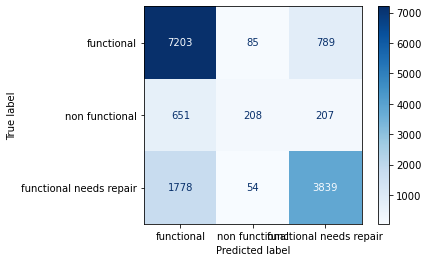

In [320]:
display_confusion_matrix(pipe_RF_test, X_test[test_], y_test)

# Results

In [341]:
rf = RandomForestClassifier(max_features='sqrt',
                            min_samples_leaf = 2,
                            min_samples_split=2,
                            n_estimators = 820,
                            max_depth = 60,
                            random_state = 42                   
                           )
rf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=60, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=820, random_state=42)

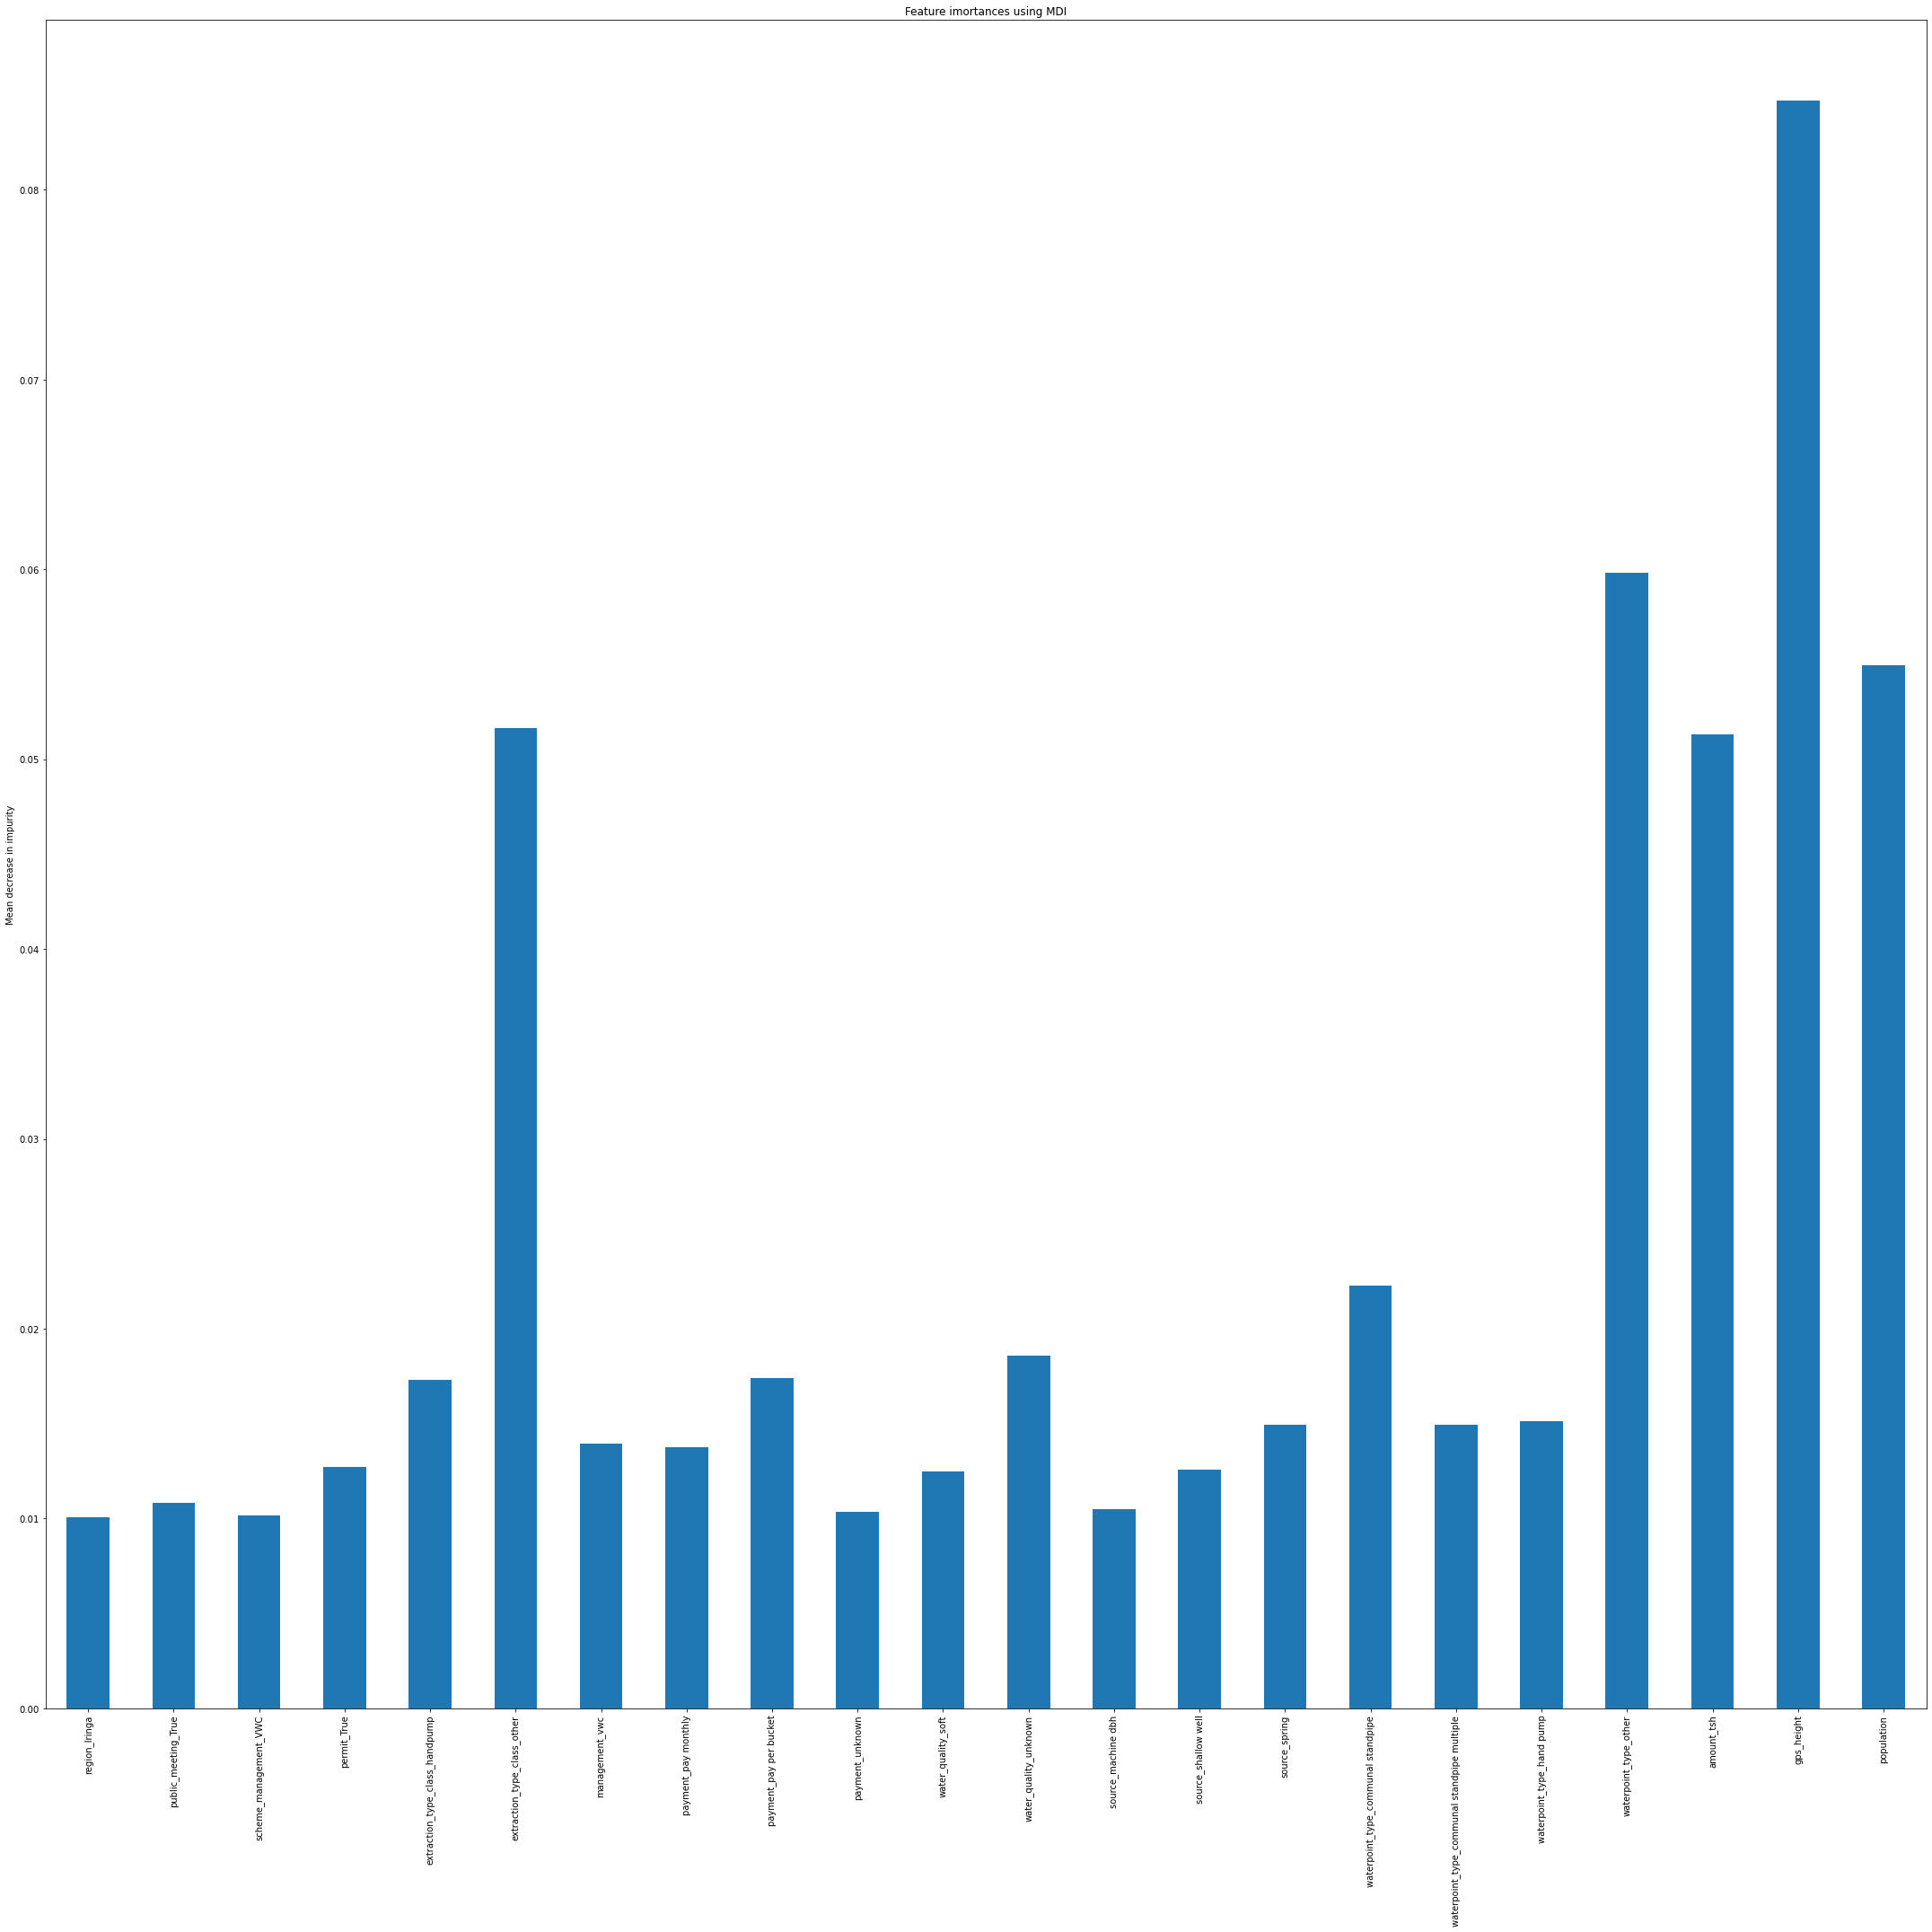

In [526]:
#Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature 
# importance as the sum over the number of splits (across all tress) that include 
# the feature, proportionally to the number of samples it splits.





importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train_processed.columns)

fig, ax = plt.subplots(figsize=(30,30))
most_important = forest_importances.loc[forest_importances > .01]
most_important.plot.bar(ax=ax)
ax.set_title("Feature imortances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [455]:
gps_greater_than_ten = data_trimmed.loc[data_trimmed.gps_height > 10]

In [456]:
gps_less_than_neg_ten = data_trimmed.loc[data_trimmed.gps_height < -10]

Text(0.5, 1.0, 'GPS Altitude less than negative 10')

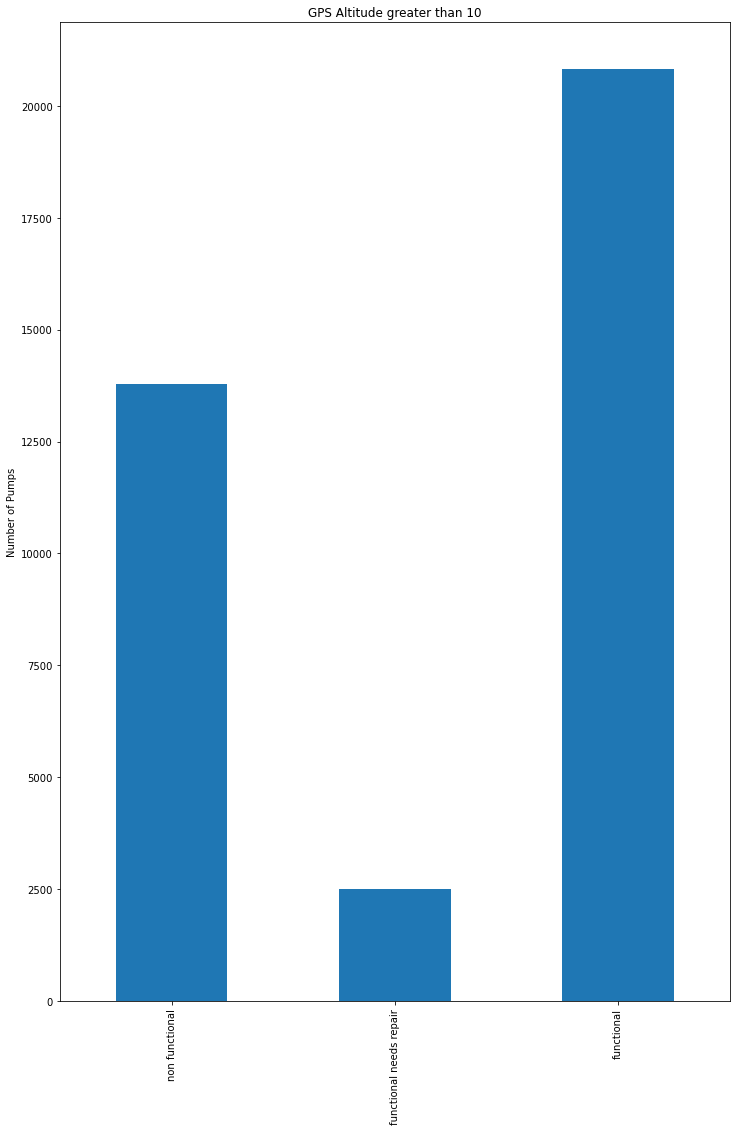

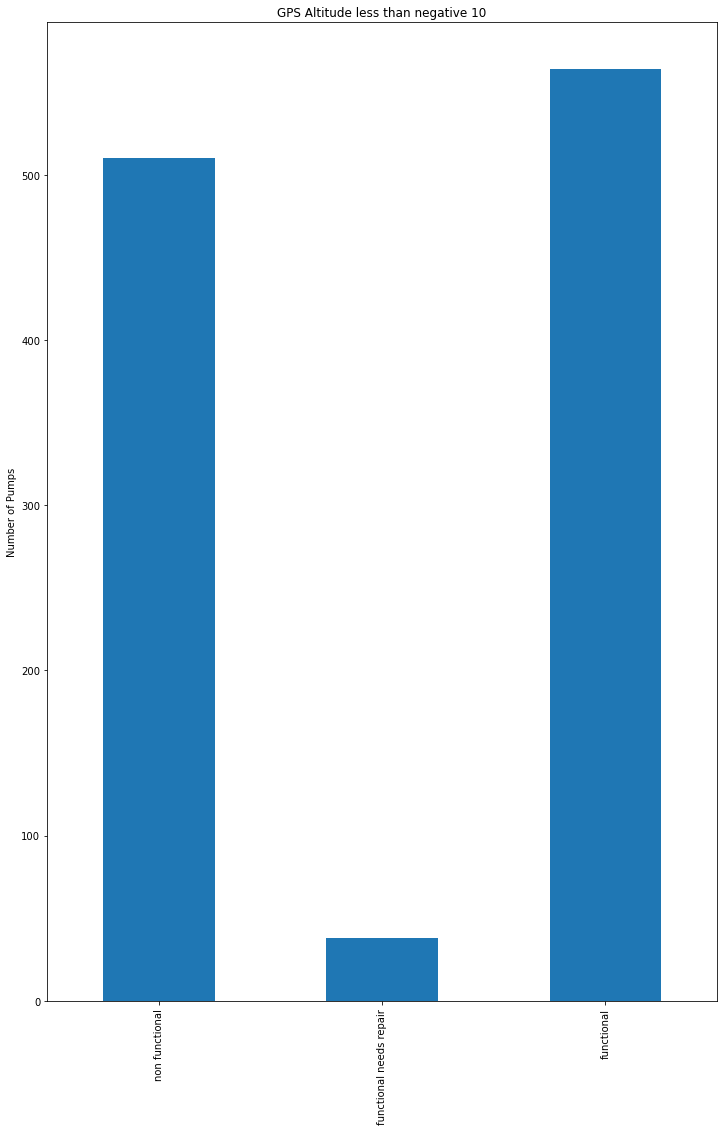

In [469]:

fig, ax = plt.subplots()

ax = gps_greater_than_ten.target.value_counts().sort_index(ascending=False).plot(kind='bar')
ax.set_ylabel('Number of Pumps')
ax.set_title('GPS Altitude greater than 10')

fig, ax = plt.subplots()
ax = gps_less_than_neg_ten.target.value_counts().sort_index(ascending=False).plot(kind='bar')
ax.set_ylabel('Number of Pumps')
ax.set_title('GPS Altitude less than negative 10')


## We can conclude that lower altitudes have a lower ration of functional : not/functional

In [393]:
data_trimmed.waterpoint_type.value_counts()

communal standpipe             28483
hand pump                      17452
other                           6339
communal standpipe multiple     6080
improved spring                  784
cattle trough                    115
Name: waterpoint_type, dtype: int64

Text(0.5, 1.0, 'Target dist when waterpoint_type is known')

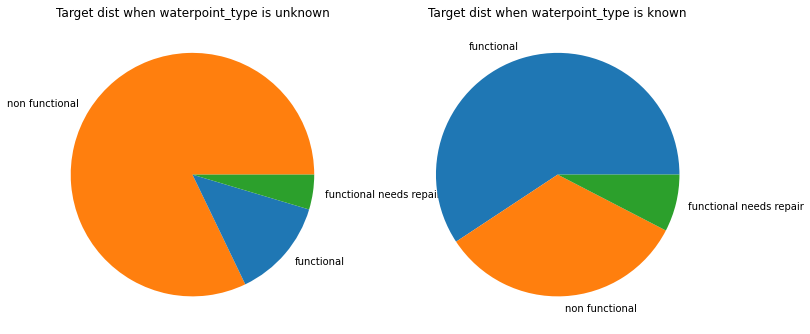

In [428]:
labels_one = data_trimmed.loc[data_trimmed.waterpoint_type == 'other'].target.value_counts().keys()
sizes_one = data_trimmed.loc[data_trimmed.waterpoint_type == 'other'].target.value_counts().values

labels_two = data_trimmed.loc[data_trimmed.waterpoint_type != 'other'].target.value_counts().keys()
sizes_two = data_trimmed.loc[data_trimmed.waterpoint_type != 'other'].target.value_counts().values
colours = {'functional': 'C0',
           'non functional': 'C1',
           'functional needs repair': 'C2',}

fig, ax = plt.subplots(1, 2)

ax[0].pie(sizes_one,
          labels=labels_one,
          colors=[colours[key] for key in labels_one])
ax[0].set_title("Target dist when waterpoint_type is unknown")

ax[1].pie(sizes_two,
          labels=labels_two,
          colors=[colours[key] for key in labels_two])
ax[1].set_title("Target dist when waterpoint_type is known")



## We can conclude that areas with an unknown water point type are output more non functional water pumps

In [409]:
data_trimmed.extraction_type.value_counts()

gravity              26735
nira/tanira           8132
other                 6386
submersible           4744
swn 80                3664
mono                  2865
india mark ii         2397
afridev               1768
ksb                   1414
other - rope pump      451
other - swn 81         229
windmill               115
india mark iii          98
cemo                    90
other - play pump       85
walimi                  48
climax                  32
Name: extraction_type, dtype: int64

Text(0.5, 1.0, 'Target dist when extraction_type is known')

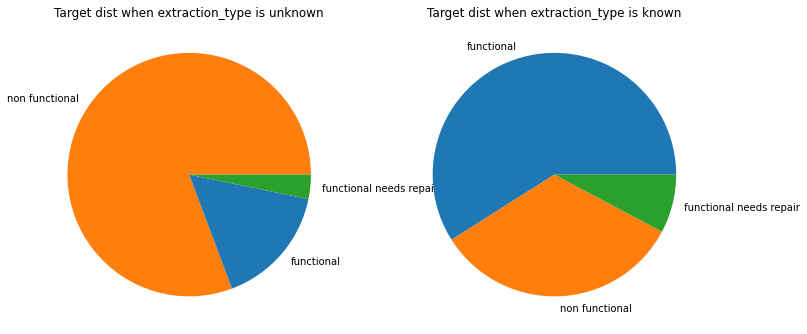

In [435]:
labels_one = data_trimmed.loc[data_trimmed.extraction_type == 'other'].target.value_counts().keys()
sizes_one = data_trimmed.loc[data_trimmed.extraction_type == 'other'].target.value_counts().values

labels_two = data_trimmed.loc[data_trimmed.extraction_type != 'other'].target.value_counts().keys()
sizes_two = data_trimmed.loc[data_trimmed.extraction_type != 'other'].target.value_counts().values
colours = {'functional': 'C0',
           'non functional': 'C1',
           'functional needs repair': 'C2',}

fig, ax = plt.subplots(1, 2)

ax[0].pie(sizes_one,
          labels=labels_one,
          colors=[colours[key] for key in labels_one])
ax[0].set_title("Target dist when extraction_type is unknown")

ax[1].pie(sizes_two,
          labels=labels_two,
          colors=[colours[key] for key in labels_two])
ax[1].set_title("Target dist when extraction_type is known")


# Conclusions
### Based on the results we can confidently confirm the following conclusions:
    -Lower altitude is causing problems
    -Where waterpoint type is unkown there are less functional water pumps
    -Where exttraction type is unknown there are less functional water pumps
      

# Further Work
### Provided more time with this data, I am certain I can derive the following insights;
- How pump functionality from differs region to region
- How population can affect water-pump functionality
- Determine how much water availability affect pump functionality